# NB11b: Extended Conservation — Full Pangenome Query

**Goal**: Replace the limited 48-organism conservation measurement with true pangenome-wide
species distribution for dark gene ortholog groups.

**Problem**: NB11's Spark query joined our gene_cluster_ids (from 48 FB organisms) to the
pangenome gene_cluster table, but only found the *same* clusters — not all clusters across
27,690 species that share the same eggNOG ortholog group. Species counts were bounded at 33.

**Fix**: Search ALL 93.5M eggnog_mapper_annotations across the full pangenome for genes
containing our 11,774 root_ogs in their eggNOG_OGs field, then aggregate species and taxonomy.

**Approaches implemented**:
- **Approach 0**: Full pangenome Spark query via eggNOG_OGs explode
- **Approach 1**: OG_id propagation for dark genes without root_og

In [1]:
import os
import pandas as pd
import numpy as np

DATA_DIR = os.path.join(os.path.dirname(os.getcwd()), "data")
if not os.path.isdir(DATA_DIR):
    DATA_DIR = "data"

# Load existing data
dark = pd.read_csv(os.path.join(DATA_DIR, "dark_genes_integrated.tsv"), sep="\t")
dark = dark[dark["is_dark"] == True].copy()
phylo = pd.read_csv(os.path.join(DATA_DIR, "phylogenetic_breadth.tsv"), sep="\t")

print(f"Dark genes: {len(dark):,}")
print(f"Phylogenetic breadth: {len(phylo):,} clusters, {phylo['root_og'].nunique():,} unique root_ogs")
print(f"Dark genes with gene_cluster_id: {dark['gene_cluster_id'].notna().sum():,}")
print(f"Dark genes linked to root_og: {dark['gene_cluster_id'].isin(phylo['gene_cluster_id']).sum():,}")

/tmp/ipykernel_86291/373693333.py:10: DtypeWarning: Columns (0: gene, 1: module, 2: familyId, 3: module_prediction, 4: prediction_source, 5: top_cofit_partners) have mixed types. Specify dtype option on import or set low_memory=False.
  dark = pd.read_csv(os.path.join(DATA_DIR, "dark_genes_integrated.tsv"), sep="\t")


Dark genes: 57,011
Phylogenetic breadth: 30,756 clusters, 11,774 unique root_ogs
Dark genes with gene_cluster_id: 39,532
Dark genes linked to root_og: 32,791


## Section 1: Full Pangenome Spark Query (Approach 0)

**Strategy**: Explode the eggNOG_OGs comma-separated field in `eggnog_mapper_annotations`
(93.5M rows), extract OG IDs (before the `@`), join to our 11,774 root_ogs, then aggregate
species and taxonomy from the full 27,690-species pangenome.

Expected runtime: 15-40 min.

In [2]:
# Get unique root_ogs to query
dark_gc_ids = set(dark["gene_cluster_id"].dropna())
dark_root_ogs = phylo[phylo["gene_cluster_id"].isin(dark_gc_ids)]["root_og"].unique()
print(f"Root OGs to query: {len(dark_root_ogs):,}")

# Breakdown: COG-style (root level) vs intermediate
cog_style = [og for og in dark_root_ogs if og.startswith(('COG', 'NOG', 'KOG', 'arCOG'))]
non_cog = [og for og in dark_root_ogs if og not in set(cog_style)]
print(f"COG-style (truly root level, @1/@2): {len(cog_style):,}")
print(f"Non-COG (intermediate taxonomic level): {len(non_cog):,}")

Root OGs to query: 11,774


COG-style (truly root level, @1/@2): 2,890
Non-COG (intermediate taxonomic level): 8,884


In [3]:
# Establish Spark session
from pyspark.sql import SparkSession
import time

token = os.environ.get("KBASE_AUTH_TOKEN", "")
spark_url = f"sc://jupyter-aparkin.jupyterhub-prod:15002/;use_ssl=false;x-kbase-token={token}"

spark = (SparkSession.builder
    .remote(spark_url)
    .getOrCreate())
print("Spark session established")

Spark session established


In [4]:
# Upload root_ogs as temp view for efficient join
root_og_df = pd.DataFrame({"root_og": dark_root_ogs})
spark_root_ogs = spark.createDataFrame(root_og_df)
spark_root_ogs.createOrReplaceTempView("target_root_ogs")
print(f"Registered {len(root_og_df):,} root_ogs as temp view")

Registered 11,774 root_ogs as temp view


In [5]:
# Full pangenome query: explode eggNOG_OGs, extract OG IDs, join to our targets
#
# eggNOG_OGs format: "COG1073@1|root,COG1073@2|Bacteria,2GVYQ@201174|Actinobacteria"
# Each entry has: OG_ID@tax_level|tax_name
# We extract the OG_ID (before @) from each exploded entry and match against our root_ogs.
#
# This finds ALL gene clusters across 27,690 species that share any of our root_ogs,
# not just the 48 FB organism gene clusters.

t0 = time.time()

pangenome_dist = spark.sql("""
WITH exploded AS (
    SELECT
        ema.query_name as gene_cluster_id,
        split(og_entry, '@')[0] as og_id
    FROM kbase_ke_pangenome.eggnog_mapper_annotations ema
    LATERAL VIEW explode(split(ema.eggNOG_OGs, ',')) t AS og_entry
    WHERE ema.eggNOG_OGs IS NOT NULL
),
matched AS (
    SELECT DISTINCT
        tro.root_og,
        e.gene_cluster_id
    FROM exploded e
    JOIN target_root_ogs tro ON tro.root_og = e.og_id
),
with_species AS (
    SELECT
        m.root_og,
        gc.gtdb_species_clade_id,
        split(split(gsc.GTDB_taxonomy, ';')[1], '__')[1] as phylum,
        split(split(gsc.GTDB_taxonomy, ';')[2], '__')[1] as class,
        split(split(gsc.GTDB_taxonomy, ';')[3], '__')[1] as ord,
        split(split(gsc.GTDB_taxonomy, ';')[4], '__')[1] as family,
        split(split(gsc.GTDB_taxonomy, ';')[5], '__')[1] as genus
    FROM matched m
    JOIN kbase_ke_pangenome.gene_cluster gc
        ON gc.gene_cluster_id = m.gene_cluster_id
    JOIN kbase_ke_pangenome.gtdb_species_clade gsc
        ON gsc.gtdb_species_clade_id = gc.gtdb_species_clade_id
)
SELECT
    root_og,
    COUNT(DISTINCT gtdb_species_clade_id) as n_species,
    COUNT(DISTINCT phylum) as n_phyla,
    COUNT(DISTINCT class) as n_classes,
    COUNT(DISTINCT ord) as n_orders,
    COUNT(DISTINCT family) as n_families,
    COUNT(DISTINCT genus) as n_genera,
    COLLECT_SET(phylum) as phyla_set
FROM with_species
GROUP BY root_og
""").toPandas()

elapsed = time.time() - t0
print(f"Query completed in {elapsed/60:.1f} min")
print(f"Root OGs returned: {len(pangenome_dist):,} / {len(dark_root_ogs):,} expected")
print(f"Species range: {pangenome_dist['n_species'].min()} - {pangenome_dist['n_species'].max()}")
print(f"Phyla range: {pangenome_dist['n_phyla'].min()} - {pangenome_dist['n_phyla'].max()}")
print(f"\nSpecies distribution quantiles:")
print(pangenome_dist['n_species'].describe(percentiles=[.25, .5, .75, .9, .95, .99]))

Query completed in 7.4 min
Root OGs returned: 11,774 / 11,774 expected
Species range: 1 - 27482
Phyla range: 1 - 142

Species distribution quantiles:
count    11774.000000
mean      2128.211993
std       4979.781327
min          1.000000
25%         43.000000
50%        135.000000
75%        799.000000
90%       7529.900000
95%      14236.900000
99%      24463.860000
max      27482.000000
Name: n_species, dtype: float64


In [6]:
# Compare old (FB-only) vs new (full pangenome) distribution
old_dist = pd.read_csv(os.path.join(DATA_DIR, "og_pangenome_distribution.tsv"), sep="\t")

comparison = old_dist[["root_og", "n_species"]].rename(columns={"n_species": "n_species_old"}).merge(
    pangenome_dist[["root_og", "n_species"]].rename(columns={"n_species": "n_species_new"}),
    on="root_og", how="outer"
)
comparison["ratio"] = comparison["n_species_new"] / comparison["n_species_old"]

print(f"OGs in old: {comparison['n_species_old'].notna().sum():,}")
print(f"OGs in new: {comparison['n_species_new'].notna().sum():,}")
print(f"\nSpecies count increase (median ratio): {comparison['ratio'].median():.1f}x")
print(f"Max old: {comparison['n_species_old'].max():.0f}, Max new: {comparison['n_species_new'].max():.0f}")
print(f"\nOGs where new > old: {(comparison['ratio'] > 1).sum():,} / {len(comparison):,}")
print(f"OGs where new = old: {(comparison['ratio'] == 1).sum():,} / {len(comparison):,}")

# Show most dramatic improvements
top_gains = comparison.nlargest(20, "ratio")
print(f"\nTop 20 species count increases:")
print(top_gains[["root_og", "n_species_old", "n_species_new", "ratio"]].to_string(index=False))

OGs in old: 11,774
OGs in new: 11,774

Species count increase (median ratio): 103.0x
Max old: 33, Max new: 27482

OGs where new > old: 11,710 / 11,774
OGs where new = old: 64 / 11,774

Top 20 species count increases:
root_og  n_species_old  n_species_new   ratio
COG0018              1          27473 27473.0
COG0525              1          27470 27470.0
COG0468              1          27427 27427.0
COG0550              1          27312 27312.0
COG0443              1          27279 27279.0
COG0030              1          27200 27200.0
COG0750              1          27009 27009.0
COG0086              1          26949 26949.0
COG0322              1          26825 26825.0
COG0272              1          26422 26422.0
COG0006              1          26414 26414.0
COG0653              1          26396 26396.0
COG0275              1          26391 26391.0
COG0465              1          26332 26332.0
COG0112              1          26094 26094.0
COG0568              1          26038 26038.0
C

In [7]:
# Save full pangenome distribution (overwrite the limited version)
# Back up the old one first
import shutil
old_path = os.path.join(DATA_DIR, "og_pangenome_distribution.tsv")
backup_path = os.path.join(DATA_DIR, "og_pangenome_distribution_fb_only.tsv")
if os.path.exists(old_path) and not os.path.exists(backup_path):
    shutil.copy2(old_path, backup_path)
    print(f"Backed up old distribution to {backup_path}")

pangenome_dist.to_csv(old_path, sep="\t", index=False)
print(f"Saved {len(pangenome_dist):,} rows to {old_path}")

Backed up old distribution to data/og_pangenome_distribution_fb_only.tsv


Saved 11,774 rows to data/og_pangenome_distribution.tsv


## Section 2: OG_id Propagation (Approach 1)

For dark genes that have an OG_id (from the 48-organism ortholog grouping) but no root_og
(because they lack a gene_cluster_id in the pangenome), we can propagate the root_og from
other genes in the same OG that DO have one.

In [8]:
# Build OG_id → root_og mapping from genes that have both
gc_to_root = phylo[["gene_cluster_id", "root_og"]].drop_duplicates("gene_cluster_id")
dark_mapped = dark.merge(gc_to_root, on="gene_cluster_id", how="left")

has_root_og = dark_mapped["root_og"].notna()
has_og_id = dark_mapped["OG_id"].notna()

print(f"Dark genes with root_og (direct): {has_root_og.sum():,}")
print(f"Dark genes with OG_id: {has_og_id.sum():,}")
print(f"Dark genes with OG_id but no root_og: {(has_og_id & ~has_root_og).sum():,}")
print(f"Dark genes with neither: {(~has_og_id & ~has_root_og).sum():,}")

Dark genes with root_og (direct): 32,791
Dark genes with OG_id: 29,295
Dark genes with OG_id but no root_og: 7,346
Dark genes with neither: 16,874


In [9]:
# For each OG_id, find the most common root_og among members that have one
og_root_map = (
    dark_mapped[dark_mapped["root_og"].notna()]
    .groupby("OG_id")["root_og"]
    .agg(lambda x: x.value_counts().index[0])  # most common root_og
    .reset_index()
    .rename(columns={"root_og": "propagated_root_og"})
)
print(f"OG_ids with known root_og: {len(og_root_map):,}")

# Propagate to genes that have OG_id but no root_og
needs_prop = dark_mapped[has_og_id & ~has_root_og].copy()
needs_prop = needs_prop.merge(og_root_map, on="OG_id", how="left")
n_propagated = needs_prop["propagated_root_og"].notna().sum()
n_unpropagated = needs_prop["propagated_root_og"].isna().sum()

print(f"\nOG_id propagation results:")
print(f"  Successfully propagated: {n_propagated:,}")
print(f"  No root_og available in OG: {n_unpropagated:,}")
print(f"  Recovery rate: {n_propagated / len(needs_prop) * 100:.1f}%")

OG_ids with known root_og: 7,898

OG_id propagation results:
  Successfully propagated: 5,206
  No root_og available in OG: 2,140
  Recovery rate: 70.9%


In [10]:
# Save the OG_id → root_og propagation mapping
prop_path = os.path.join(DATA_DIR, "og_id_root_propagation.tsv")
og_root_map.to_csv(prop_path, sep="\t", index=False)
print(f"Saved {len(og_root_map):,} OG_id → root_og mappings to {prop_path}")

# Summary of total coverage
total_with_root = has_root_og.sum() + n_propagated
total_dark = len(dark)
print(f"\nTotal dark gene coverage:")
print(f"  Direct root_og: {has_root_og.sum():,} ({has_root_og.sum()/total_dark*100:.1f}%)")
print(f"  + OG_id propagation: {n_propagated:,} ({n_propagated/total_dark*100:.1f}%)")
print(f"  = Total with root_og: {total_with_root:,} ({total_with_root/total_dark*100:.1f}%)")
print(f"  Remaining unlinked: {total_dark - total_with_root:,} ({(total_dark - total_with_root)/total_dark*100:.1f}%)")

Saved 7,898 OG_id → root_og mappings to data/og_id_root_propagation.tsv

Total dark gene coverage:
  Direct root_og: 32,791 (57.5%)
  + OG_id propagation: 5,206 (9.1%)
  = Total with root_og: 37,997 (66.6%)
  Remaining unlinked: 19,014 (33.4%)


## Section 3: Validation

Verify the full pangenome distribution makes biological sense.

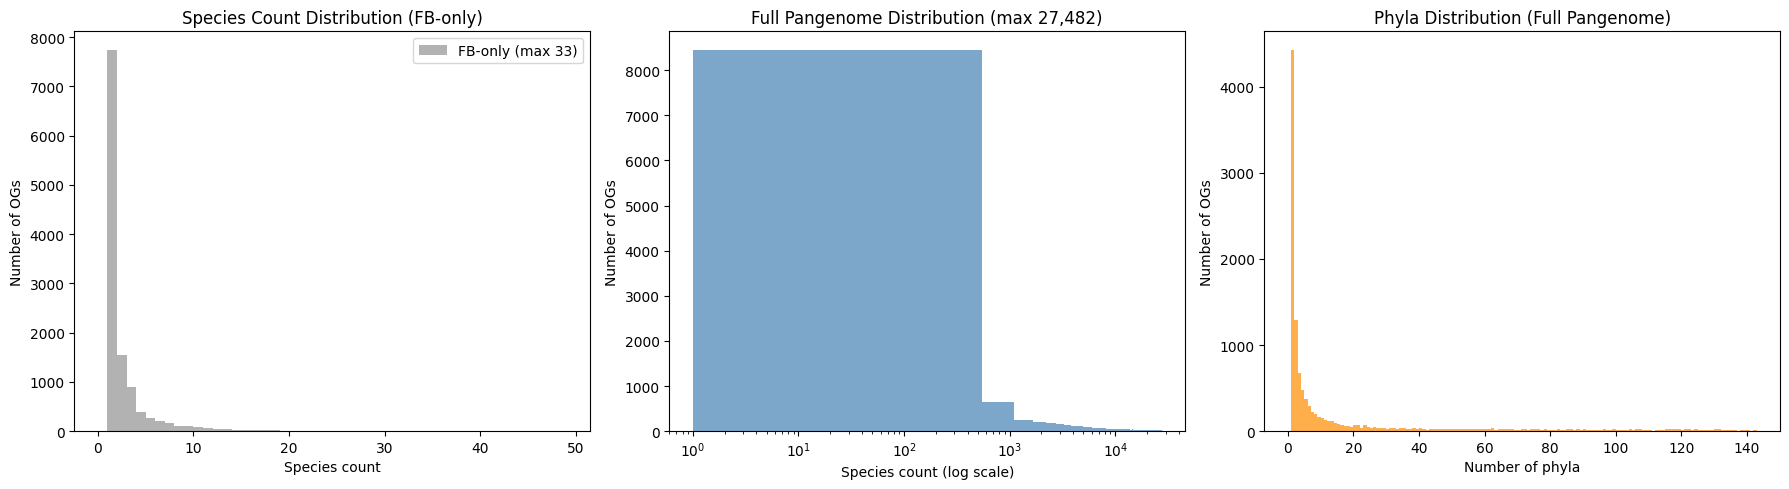

Saved to figures/fig38_pangenome_species_distribution.png


In [11]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Species count distribution: old vs new
ax = axes[0]
ax.hist(old_dist["n_species"], bins=range(0, 50), alpha=0.6, label="FB-only (max 33)", color="gray")
bins_new = np.logspace(0, np.log10(pangenome_dist["n_species"].max() + 1), 50)
ax.set_xlabel("Species count")
ax.set_ylabel("Number of OGs")
ax.set_title("Species Count Distribution (FB-only)")
ax.legend()

# 2. New distribution (log scale)
ax = axes[1]
ax.hist(pangenome_dist["n_species"], bins=50, alpha=0.7, color="steelblue")
ax.set_xscale("log")
ax.set_xlabel("Species count (log scale)")
ax.set_ylabel("Number of OGs")
ax.set_title(f"Full Pangenome Distribution (max {pangenome_dist['n_species'].max():,})")

# 3. Phyla count distribution
ax = axes[2]
ax.hist(pangenome_dist["n_phyla"], bins=range(0, pangenome_dist["n_phyla"].max() + 2),
        alpha=0.7, color="darkorange")
ax.set_xlabel("Number of phyla")
ax.set_ylabel("Number of OGs")
ax.set_title("Phyla Distribution (Full Pangenome)")

plt.tight_layout()
fig_path = os.path.join(os.path.dirname(DATA_DIR), "figures", "fig38_pangenome_species_distribution.png")
plt.savefig(fig_path, dpi=150, bbox_inches="tight")
plt.show()
print(f"Saved to {fig_path}")

In [12]:
# Tier classification using full pangenome data
# (Preview — actual reclassification happens when NB11 is re-run)
def classify_tier(row):
    n_phyla = row["n_phyla"]
    n_species = row["n_species"]
    n_classes = row["n_classes"]
    n_orders = row["n_orders"]
    n_families = row["n_families"]
    n_genera = row["n_genera"]
    # Mobile detection: present in distant phyla but few species per phylum
    if n_phyla >= 2 and n_species / n_phyla <= 10:
        return "mobile"
    if n_phyla > 1:
        return "kingdom"
    if n_classes > 1:
        return "phylum"
    if n_orders > 1:
        return "class"
    if n_families > 1:
        return "order"
    if n_genera > 1:
        return "family"
    if n_species > 1:
        return "genus"
    return "species"

pangenome_dist["taxonomic_tier"] = pangenome_dist.apply(classify_tier, axis=1)
tier_counts = pangenome_dist["taxonomic_tier"].value_counts()
tier_pct = pangenome_dist["taxonomic_tier"].value_counts(normalize=True) * 100

print("Taxonomic tier distribution (full pangenome):")
for tier in ["kingdom", "phylum", "class", "order", "family", "genus", "species", "mobile"]:
    if tier in tier_counts:
        print(f"  {tier:10s}: {tier_counts[tier]:6,} ({tier_pct[tier]:5.1f}%)")
    else:
        print(f"  {tier:10s}: {0:6,} ({0:5.1f}%)")

print(f"\nCompare with FB-only:")
print(f"  Old max species: {old_dist['n_species'].max()}, New max species: {pangenome_dist['n_species'].max():,}")
print(f"  Old single-species OGs: {(old_dist['n_species'] == 1).sum():,}")
print(f"  New single-species OGs: {(pangenome_dist['n_species'] == 1).sum():,}")

Taxonomic tier distribution (full pangenome):
  kingdom   :  6,581 ( 55.9%)
  phylum    :    563 (  4.8%)
  class     :  1,297 ( 11.0%)
  order     :    457 (  3.9%)
  family    :  1,231 ( 10.5%)
  genus     :    812 (  6.9%)
  species   :     63 (  0.5%)
  mobile    :    770 (  6.5%)

Compare with FB-only:
  Old max species: 33, New max species: 27,482
  Old single-species OGs: 7,730
  New single-species OGs: 63


In [13]:
# Summary stats
print("=" * 60)
print("NB11b Extended Conservation Summary")
print("=" * 60)
print(f"\nApproach 0: Full pangenome Spark query")
print(f"  Root OGs queried: {len(dark_root_ogs):,}")
print(f"  Root OGs returned: {len(pangenome_dist):,}")
print(f"  Species range: {pangenome_dist['n_species'].min()} - {pangenome_dist['n_species'].max():,}")
print(f"  Median species: {pangenome_dist['n_species'].median():.0f}")
print(f"\nApproach 1: OG_id propagation")
print(f"  Genes propagated: {n_propagated:,}")
print(f"  New total with root_og: {total_with_root:,} / {total_dark:,} ({total_with_root/total_dark*100:.1f}%)")
print(f"\nTier distribution (full pangenome):")
for tier in ["kingdom", "phylum", "class", "order", "family", "genus", "species", "mobile"]:
    n = tier_counts.get(tier, 0)
    pct = tier_pct.get(tier, 0)
    print(f"  {tier:10s}: {n:6,} ({pct:5.1f}%)")
print(f"\nOutput files:")
print(f"  og_pangenome_distribution.tsv: {len(pangenome_dist):,} rows (full pangenome)")
print(f"  og_pangenome_distribution_fb_only.tsv: backup of original")
print(f"  og_id_root_propagation.tsv: {len(og_root_map):,} OG_id → root_og mappings")

NB11b Extended Conservation Summary

Approach 0: Full pangenome Spark query
  Root OGs queried: 11,774
  Root OGs returned: 11,774
  Species range: 1 - 27,482
  Median species: 135

Approach 1: OG_id propagation
  Genes propagated: 5,206
  New total with root_og: 37,997 / 57,011 (66.6%)

Tier distribution (full pangenome):
  kingdom   :  6,581 ( 55.9%)
  phylum    :    563 (  4.8%)
  class     :  1,297 ( 11.0%)
  order     :    457 (  3.9%)
  family    :  1,231 ( 10.5%)
  genus     :    812 (  6.9%)
  species   :     63 (  0.5%)
  mobile    :    770 (  6.5%)

Output files:
  og_pangenome_distribution.tsv: 11,774 rows (full pangenome)
  og_pangenome_distribution_fb_only.tsv: backup of original
  og_id_root_propagation.tsv: 7,898 OG_id → root_og mappings
